In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

# 1. 建立 VGG16 模型
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # 冻结 VGG16 層

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)  # 添加全連接層
    predictions = Dense(2, activation='softmax')(x)  # 二分類輸出

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. 清理圖片數據（將透明 PNG 轉換為 RGB）
def convert_to_rgb(image_dir):
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                img = Image.open(file_path)
                if img.mode != "RGB":
                    img = img.convert("RGB")
                    img.save(file_path)
                # print(f"Converted {file_path} to RGB")

# 3. 準備資料
def prepare_data():
    train_dir = "./train"
    datagen = ImageDataGenerator(
        rescale=1.0/255,  # 正規化圖片
        validation_split=0.2,  # 驗證集分割比例
        rotation_range=20,  # 隨機旋轉
        width_shift_range=0.2,  # 水平位移
        height_shift_range=0.2,  # 垂直位移
        shear_range=0.2,  # 隨機剪切
        zoom_range=0.2,  # 隨機縮放
        horizontal_flip=True  # 隨機水平翻轉
    )

    # 訓練資料生成器
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    # 驗證資料生成器
    val_data = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_data, val_data

# 主程式
if __name__ == "__main__":
    # 1. 清理資料集中的透明圖片
    print("Converting transparent PNG images to RGB...")
    convert_to_rgb("./train")
    convert_to_rgb("./test")

    # 2. 建立模型
    model = build_model()

    # 3. 準備資料
    train_data, val_data = prepare_data()

    # 4. 訓練模型
    print("Starting training...")
    model.fit(train_data, validation_data=val_data, epochs=5)
    print("Training completed!")

    # 5. 保存模型
    model.save("mask.h5")
    print("Model saved as 'mask.h5'")

Converting transparent PNG images to RGB...
Found 3126 images belonging to 2 classes.
Found 781 images belonging to 2 classes.
Starting training...


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8260 - loss: 0.6300

c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8268 - loss: 0.6266 - val_accuracy: 0.9616 - val_loss: 0.1018
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9675 - loss: 0.0853 - val_accuracy: 0.9795 - val_loss: 0.0609
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9716 - loss: 0.0862 - val_accuracy: 0.9757 - val_loss: 0.0623
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9801 - loss: 0.0611 - val_accuracy: 0.9731 - val_loss: 0.0678
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9795 - loss: 0.0484 - val_accuracy: 0.9770 - val_loss: 0.0635


Training completed!
Model saved as 'mask.h5'


Model loaded successfully!
Error processing the image: Invalid URL. Please provide a valid HTTP/HTTPS URL.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
The image is classified as: with_mask
Prediction probabilities: [[0.95841527 0.04158481]]


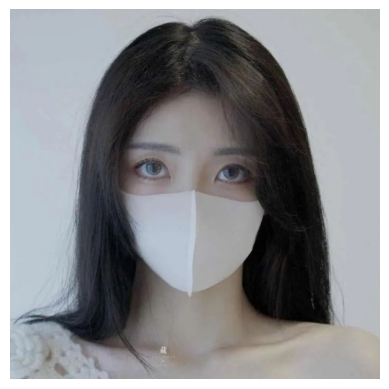

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
The image is classified as: without_mask
Prediction probabilities: [[0.00703076 0.9929692 ]]


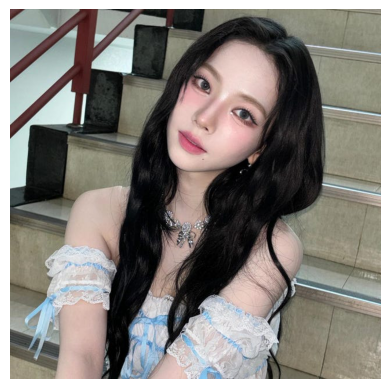

Exiting the program. Goodbye!


In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import requests
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# 測試圖片分類
def test_image(url, model, class_indices):
    try:
        # 驗證 URL
        if not url.startswith("http://") and not url.startswith("https://"):
            raise ValueError("Invalid URL. Please provide a valid HTTP/HTTPS URL.")

        # 下載圖片
        response = requests.get(url, stream=True)
        response.raw.decode_content = True
        img = Image.open(response.raw)
        
        # 保存原始圖片尺寸
        original_image = np.asarray(img)
        
        # 調整圖片大小進行模型預測
        img = img.resize((224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 模型預測
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class)]

        # 打印分類結果
        print(f"The image is classified as: {class_name}")
        print(f"Prediction probabilities: {prediction}")

        # 顯示原始圖片（不變形）
        plt.imshow(original_image)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing the image: {e}")

# 主程式
if __name__ == "__main__":
    # 檢查模型文件是否存在
    model_path = "mask.h5"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file '{model_path}' not found. Please ensure the model file exists.")

    # 加載模型
    model = load_model(model_path)
    print("Model loaded successfully!")

    # 手動設置類別索引
    class_indices = {'with_mask': 0, 'without_mask': 1}

    # 重複測試圖片分類直到用戶退出
    while True:
        image_url = input("\nEnter image URL (or type 'exit' to quit): ")
        if image_url.lower() == 'exit':
            print("Exiting the program. Goodbye!")
            break
        test_image(image_url, model, class_indices)